In [87]:
import pandas as pd
import plotly.express as px
from scipy.stats import hypergeom
import pymc3 as pm
import numpy as np

In [76]:
dfs = pd.read_excel('../data/human_evaluations/gr12-02.xlsx', 
                     sheet_name=None)


dfs = {sheet: df.assign(sheet_name=sheet)
       for sheet, df in dfs.items() 
       if 'Instructions' not in sheet
       and 'Squelches' not in sheet}

COL_MAP = {'Is Sybil? (T or F)': 'is_sybil',
           'Confidence (low, so-so, high)': 'confidence',
           'Unnamed: 0': 'handle'}

COLS = {'handle', 'is_sybil', 'confidence', 'Notes'}


def clean(s):
    return (s.lower().strip())

def is_sybil_clean(s):
    return s.replace('ff', 'f').replace('tt', 't')

def confidence_clean(s):
    return (s.replace('so-so-high', 'so-so')
            .replace('soso', 'so-so')
            .replace('sosos', 'so-so')
            .replace('med', 'so-so')
            .replace('figh', 'high')
            .replace('sos', 'so-so')
            .replace('so-so-so', 'so-so')
           )

df = (pd.concat(dfs.values())
        .rename(columns=COL_MAP)
        .dropna(subset=['is_sybil', 'confidence'])
        .assign(is_sybil=lambda df: df.is_sybil.map(clean).map(is_sybil_clean))
        .assign(confidence=lambda df: df.confidence.map(clean).map(confidence_clean)) 
        .drop_duplicates('handle')
     )

valid_inds = (df.is_sybil != '-') | (df.confidence != '-')
df = df.loc[valid_inds, COLS]

print(df.is_sybil.unique())
print(df.confidence.unique())


df['confidence'] = df.confidence.map({'low': 0.0, 'so-so': 0.5, 'high': 1.0})
df['is_sybil'] = df.is_sybil.map({'f': 0.0, 't': 1.0})


def f(row):
    if row.is_sybil == 1.0:
        return (3 / 5) + (2 * row.confidence / 5) 
        
    else:
        return 2 * (1 - row.confidence) / 5
    
df['score'] = df.apply(f, axis=1)

['f' 't']
['high' 'so-so' 'low']


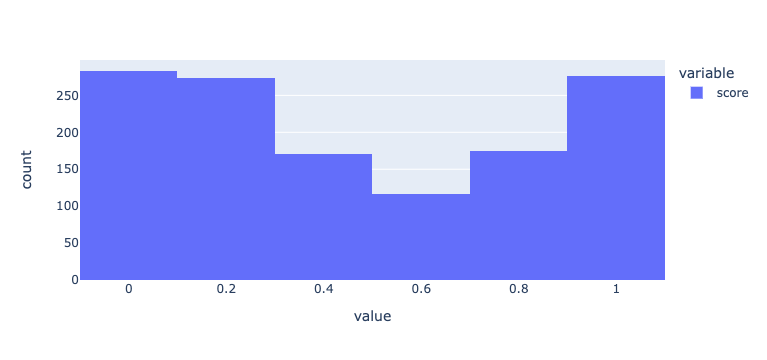

In [77]:
fig = px.histogram(df.score)
fig.show()

In [78]:
df.score.unique()

array([0. , 0.2, 1. , 0.4, 0.8, 0.6])

In [79]:
sum(df.score > 0.75) / len(df)

0.34853168469860896

In [80]:
sum(df.score > 0.95) / len(df)

0.2132921174652241

In [119]:
N = 9000
k = N * np.mean(df.score > 0.95)
n = len(df)

rv = hypergeom(N, k, n)

print(rv.stats())
print(rv.ppf(0.05) / len(df))
print(rv.ppf(0.5) / len(df))
print(rv.ppf(0.95) / len(df))

(array(276.), array(185.93336818))
0.19629057187017002
0.2132921174652241
0.23106646058732613
